# Instalación y entrega

**Los datos necesarios para realizar la práctica están en una carpeta compartida que se llama `data`, situada en "Shared with me". Para que el cuaderno pueda acceder a ella es necesario crear un link en "My Drive". El link se crea simplemente seleccionando "data", y desde el menu del botón derecho seleccione "Add a shortcut to Drive".**

**Una vez hecho esto, ejecute la siguiente celda. Esta celda montará el directorio de trabajo del cuaderno y verá la carpeta `data` a través del link. Para montar el directorio le pedirá que se registre en "Drive"**.

**En las prácticas que requieren entrenar una red es importante cambiar el entorno de trabajo para trabajar con GPU. Para ello ir a Entorno de ejecución > Cambiar tipo de entorno de ejecución.**

**Cuando termine la práctica, rellenando las celdas de código y respondiendo a las preguntas, descárguelo a su máquina. Para bajar el cuaderno hay que ir a "Archivo --> Descargar --> Descargar .ipynb". Una vez descargado lo tenéis que subir a la actividad en formato ".ipynb".**

In [1]:
## Instalación: esta celda monta el directorio de trabajo
if 'google.colab' in str(get_ipython()):
    # Setup colab
    from google.colab import drive
    drive.mount('/drive')
    %cd /drive/My Drive/data
else:
    pass

Mounted at /drive
/drive/.shortcut-targets-by-id/1MHsiAeNCqIWHIkKgK7ggxOaSkemKqWSb/data


# Redes convolucionales II

En esta práctica analizamos el proceso de extracción de características. En primer lugar volvemos a ver el ejemplo del tutorial sobre la extracción de características, pero esta vez con un **kernel** específicamente diseñado. Veremos cómo representar los mapas de características como matrices de números y el efecto de la convolución de la entrada con dicho **kernel**.

En primer lugar cargamos las librerías necesarias:

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16
import numpy as np
import pandas as pd
from data_m3.utils.visiontools import show_kernel, show_extraction, random_transform, random_map
from data_m3.utils.visiontools import read_image, edge, blur, bottom_sobel, emboss, sharpen, circle
import warnings
warnings.filterwarnings("ignore") # to clean up output cells
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=16, titlepad=10)
plt.rc('image', cmap='magma')

Antes de comenzar cargamos y mostramos la imagen inicial:

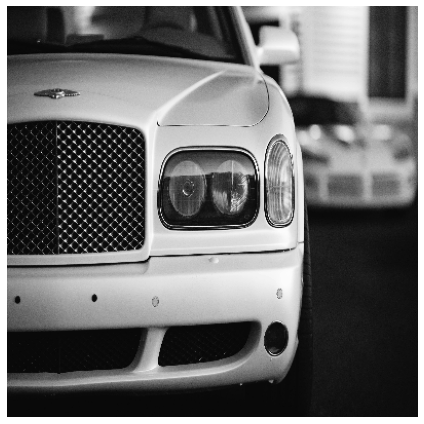

In [3]:
image_path = 'data_m3/figs/car_illus.jpg'
image = tf.io.read_file(image_path)
image = tf.io.decode_jpeg(image, channels=1)
image = tf.image.resize(image, size=[400, 400])

img = tf.squeeze(image).numpy()
plt.figure(figsize=(6, 6))
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show();

## Convolución

En primer lugar nos planteamos la definición del **kernel** de convolución. Es necesario tener en cuenta que la *suma* de los elementos del **kernel** determina la intensidad de los píxeles de la imagen final. En general, para mantener la intensidad de la imagen, la suma de los elementos del **kernel** suele estar entre 0 y 1, aunque no es imprescindible. Un **kernel** puede contener cualquier número de filas y columnas, aunque un tamaño de $3 \times 3$ suele ser suficiente para obtener buenos resultados. 

Ejecute la siguiente celda para ver algunos **kernels** estándar utilizados en procesado de imágenes.

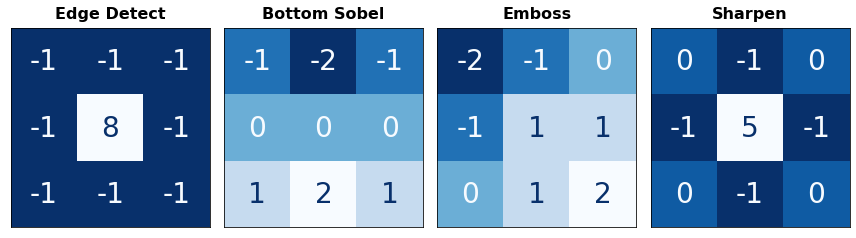

In [4]:
from data_m3.utils.visiontools import show_kernel, edge, bottom_sobel, emboss, sharpen
kernels = [edge, bottom_sobel, emboss, sharpen]
names = ["Edge Detect", "Bottom Sobel", "Emboss", "Sharpen"]

plt.figure(figsize=(12, 12))
for i, (kernel, name) in enumerate(zip(kernels, names)):
    plt.subplot(1, 4, i+1)
    show_kernel(kernel)
    plt.title(name)
plt.tight_layout()

Defina manualmente un **kernel** con la función `tf.constant` para extraer bordes horizontales de la imagen.

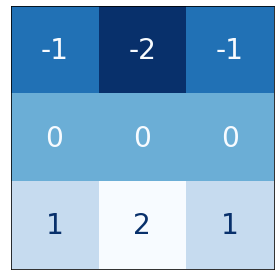

In [5]:
# EJERCICIO 1 --------- TO DO
kernel =  tf.constant(
    [[-1, -2, -1],
     [0, 0, 0],
     [1, 2, 1]],
)

show_kernel(kernel)

A continuación realizaremos el primer paso de la extracción de características, el paso del filtrado. Primero es necesario ejecutar esta celda para adaptar los datos al tipo de datos que admite **TensorFlow**.

In [6]:
# Reformat for batch compatibility.
image = tf.image.convert_image_dtype(image, dtype=tf.float32)
image = tf.expand_dims(image, axis=0)
kernel = tf.reshape(kernel, [*kernel.shape, 1, 1])
kernel = tf.cast(kernel, dtype=tf.float32)

Es el momento de aplicar el **kernel** a la imagen mediante una convolución o filtrado. Como hemos visto en el tutorial, la *capa* que hace esto en *Keras* es `layers.Conv2D`. En este caso no nos interesa crear una capa porque no estamos diseñando una red, solo queremos visualizar la operación. Para ello utilizamos una función encargada de realizar convoluciones que `TensorFlow` implementa en el módulo `tf.nn`, fuera del contexto de una red neuronal. Configure la misma función con los mismos parámetros utilizados en el tutorial.

In [7]:
# EJERCICIO 2 --------- TO DO
image_filter = tf.nn.conv2d(
    input=image,
    filters=kernel,
    strides=1,
    padding='SAME',
)

A continuación, ejecute la siguiente celda para realizar la convolución y ver el resultado

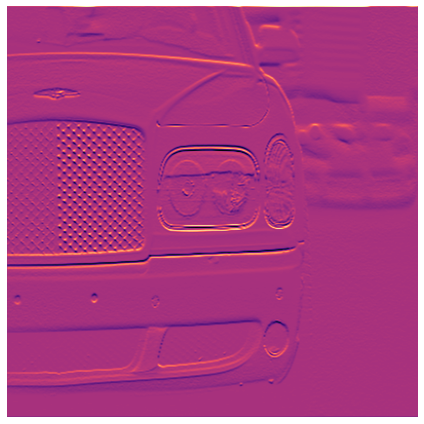

In [8]:
plt.figure(figsize=(6, 6))
plt.imshow(
    # Reformat for plotting
    tf.squeeze(image_filter)
)
plt.axis('off')
plt.show();

## Aplicación de **ReLu**

Ahora vamos a detectar las características con la función de activación **ReLu**. En *Keras* normalmente se usa la función de activación dentro de la capa `Conv2D`, pero al igual que antes, no nos interesa configurar una capa de una red, nos interesa visualizar la función de activación configurada manualmente y de forma aislada. Configure en la siguiente celda la función de activación **ReLu** que implementa el módulo `tf.nn` de **TensorFlow**.

In [9]:
# EJERCICIO 3 --------- TO DO
image_detect_ej3 = tf.nn.relu(image_filter)

Una vez aplicada la activación, ejecuta la siguiente celda para visualizar el resultado. La imagen obtenida es el mapa de características producido por el **kernel** elegido. 

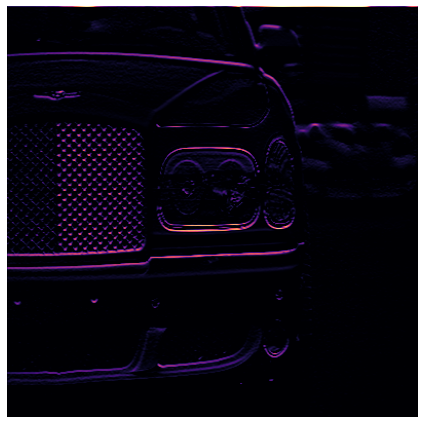

In [10]:
## visualización de la extrcción de características
plt.figure(figsize=(6, 6))
plt.imshow(
    # Reformat for plotting
    tf.squeeze(image_detect_ej3)
)
plt.axis('off')
plt.show();

A continuación, se desea generar un **kernel** para la detección de bordes verticales y otro para bordes horizontales. En la siguiente celda, complete el código necesario para representar los dos resultados, con el filtrado y la función de activación. Represente las gráficas completando el código propuesto.

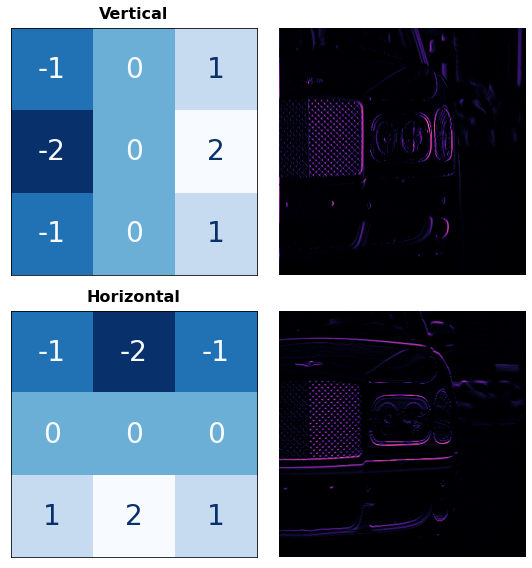

In [11]:
# EJERCICIO 4 --------- TO DO

################ VERTICAL #########################
kernel_v =  tf.constant(
            [[-1,  0, 1],
             [-2,  0, 2],
             [-1,  0, 1]],
)
plt.figure(figsize=(8, 8))
plt.subplot(2, 2, 1)
show_kernel(kernel_v)
plt.title('Vertical');
kernel = tf.reshape(kernel_v, [*kernel_v.shape, 1, 1])
kernel = tf.cast(kernel, dtype=tf.float32)
image_filter = tf.nn.conv2d(
    input=image,
    filters=kernel,
    strides=1,
    padding='SAME',
)
image_detect_v = tf.nn.relu(image_filter)
plt.subplot(2, 2, 2)
plt.imshow(tf.squeeze(image_detect_v))
plt.axis('off');

################ HORIZONTAL #########################
kernel_h =  tf.constant(
            [[-1, -2, -1],
            [0, 0, 0],
            [1, 2, 1]],
)
plt.subplot(2, 2, 3)
show_kernel(kernel_h)
plt.title('Horizontal');
kernel = tf.reshape(kernel_h, [*kernel_h.shape, 1, 1])
kernel = tf.cast(kernel, dtype=tf.float32)
image_filter = tf.nn.conv2d(
              input=image,
              filters=kernel,
              strides=1,
              padding='SAME',
)
image_detect_h = tf.nn.relu(image_filter)
plt.subplot(2, 2, 4)
plt.imshow(tf.squeeze(image_detect_h))
plt.axis('off');

## Análisis numérico de la convolución

En el tutorial hemos discutido sobre los **kernels** y los mapas de características de un modo visual. Vimos el efecto de `Conv2D` y `ReLU` observando su efecto en algunas imágenes de ejemplo. Por otro lado, las operaciones en una red neuronal suelen definirse a través de funciones matemáticas, mediante un cálculo numérico. En el siguiente ejercicio abordamos este punto de vista. Comenzamos  por definir una matriz que actúe como imagen y otra matriz que actúe como **kernel**. Ejecute la siguiente celda para ver la imagen y el **kernel**.

In [12]:
# Análisis numérico de la convolución
# Sympy is a python library for symbolic mathematics. It has a nice
# pretty printer for matrices, which is all we'll use it for.
import sympy
sympy.init_printing()
from IPython.display import display

image = np.array([
    [0, 1, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0],
    [0, 1, 0, 1, 1, 1],
    [0, 1, 0, 0, 0, 0],
])

kernel = np.array([
    [1, -1],
    [1, -1],
])

display(sympy.Matrix(image))
display(sympy.Matrix(kernel))
# Reformat for Tensorflow
image = tf.cast(image, dtype=tf.float32)
image = tf.reshape(image, [1, *image.shape, 1])
kernel = tf.reshape(kernel, [*kernel.shape, 1, 1])
kernel = tf.cast(kernel, dtype=tf.float32)

⎡0  1  0  0  0  0⎤
⎢                ⎥
⎢0  1  0  0  0  0⎥
⎢                ⎥
⎢0  1  0  0  0  0⎥
⎢                ⎥
⎢0  1  0  0  0  0⎥
⎢                ⎥
⎢0  1  0  1  1  1⎥
⎢                ⎥
⎣0  1  0  0  0  0⎦

⎡1  -1⎤
⎢     ⎥
⎣1  -1⎦

En la matriz que hace de imagen aparece una larga línea vertical a la izquierda y una corta línea horizontal en la parte inferior derecha. A continuación, en la siguiente celda, vamos a filtrar con el **Kernel** y detectar con **ReLu**. Finalmente, se muestra el resultado.

In [13]:
## Análisis numérico de la convolución
image_filter = tf.nn.conv2d(
    input=image,
    filters=kernel,
    strides=1,
    padding='VALID',
)
image_detect = tf.nn.relu(image_filter)

# The first matrix is the image after convolution, and the second is
# the image after ReLU.
display(sympy.Matrix(tf.squeeze(image_filter).numpy()))
display(sympy.Matrix(tf.squeeze(image_detect).numpy()))

⎡-2.0  2.0  0.0   0.0  0.0⎤
⎢                         ⎥
⎢-2.0  2.0  0.0   0.0  0.0⎥
⎢                         ⎥
⎢-2.0  2.0  0.0   0.0  0.0⎥
⎢                         ⎥
⎢-2.0  2.0  -1.0  0.0  0.0⎥
⎢                         ⎥
⎣-2.0  2.0  -1.0  0.0  0.0⎦

⎡0.0  2.0  0.0  0.0  0.0⎤
⎢                       ⎥
⎢0.0  2.0  0.0  0.0  0.0⎥
⎢                       ⎥
⎢0.0  2.0  0.0  0.0  0.0⎥
⎢                       ⎥
⎢0.0  2.0  0.0  0.0  0.0⎥
⎢                       ⎥
⎣0.0  2.0  0.0  0.0  0.0⎦

## Max Pooling

En esta sección realizaremos la última etapa de la extracción de características, el **MaxPooling**. Analizamos su funcionamiento y la invarianza frente a pequeños desplazamientos. Para la obtención final de las características, se pretende realizar un **MaxPooling** con una ventana de $2 \times 2$. Al igual que hemos hecho anteriormente, usamos una función incluida en el módulo `tf.nn`, sin la necesidad de definir una red neuronal. Configure la celda siguiente para realizar el **MaxPooling** sobre la **imagen del ejercicio 3**, correspondiente al mapa de detección de bordes.

In [14]:
# EJERCICIO 5 --------- TO DO
image_condense = tf.nn.pool(
    input=image_detect_ej3, # image in the Detect step above
    window_shape=(2, 2),
    pooling_type='MAX',
    # we'll see what these do in the next lesson!
    strides=(2, 2),
    padding='SAME',
)

En la celda siguiente representamos el resultado del **MaxPooling**.

El tamaño de la primera imagen es: (1, 400, 400, 1)
El tamaño de la segunda imagen es: (1, 200, 200, 1)


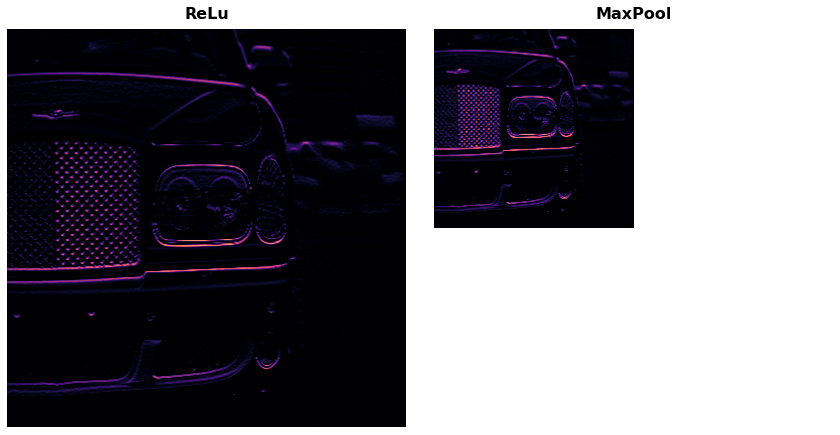

In [15]:
## Visualización del maxPooling
x,y = tf.squeeze(image_detect_ej3).shape
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(tf.squeeze(image_detect_ej3))
plt.axis([0, y, x, 0])
plt.axis('off')
plt.title('ReLu')

print("El tamaño de la primera imagen es:",image_detect_ej3.shape)
print("El tamaño de la segunda imagen es:",image_condense.shape)

plt.subplot(1, 2, 2)
plt.imshow(tf.squeeze(image_condense))
plt.axis([0, y, x, 0])
plt.axis('off')
plt.title('MaxPool')
plt.show();




En el tutorial hemos visto cómo las capas `MaxPool2D` aportan a las redes convolucionales la propiedad de **invarianza frente a pequeños desplazamientos**. Para visualizar esto, la siguiente celda aplica aleatoriamente un pequeño desplazamiento a un círculo y luego usa `maxPool` para concentrar las características de la imagen. Analice el siguiente código y ejecútelo varias veces observando el resultado.

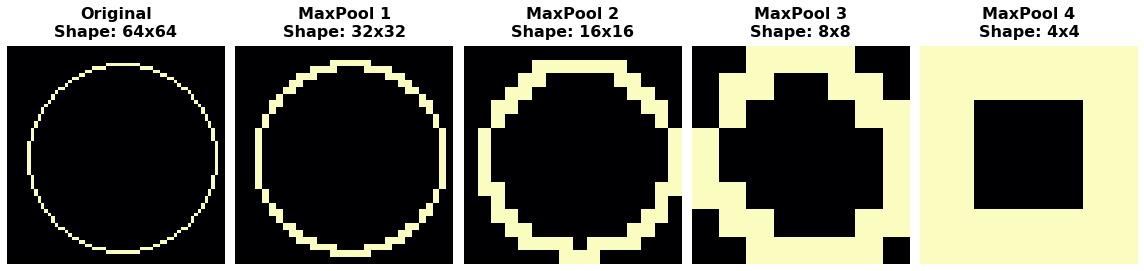

In [24]:
###  invarianza frente a pequeños desplazamientos
REPEATS = 4
SIZE = [64, 64]
# Create a randomly shifted circle
image = circle(SIZE, r_shrink=4, val=1)
image = tf.expand_dims(image, axis=-1)
image = random_transform(image, jitter=3, fill_method='replicate')
image = tf.squeeze(image)

plt.figure(figsize=(16, 4))
plt.subplot(1, REPEATS+1, 1)
plt.imshow(image, vmin=0, vmax=1)
plt.title("Original\nShape: {}x{}".format(image.shape[0], image.shape[1]))
plt.axis('off')

# Now condense with maximum pooling several times
for i in range(REPEATS):
    ax = plt.subplot(1, REPEATS+1, i+2)
    image = tf.reshape(image, [1, *image.shape, 1])
    image = tf.nn.pool(image, window_shape=(2,2), strides=(2, 2), padding='SAME', pooling_type='MAX')
    image = tf.squeeze(image)
    plt.imshow(image, vmin=0, vmax=1)
    plt.title("MaxPool {}\nShape: {}x{}".format(i+1, image.shape[0], image.shape[1]))
    plt.axis('off')

## Global Average Pooling

Para visualizar el **Global Average Pooling** consideramos imágenes de la base de datos `Car or truck`. Cargamos la red **VGG16** que hemos utilizado en el tutorial sobre el clasificador convolucional. Posteriormente realizamos la extracción de características y visualizamos los promedios de las características mediante **GlobalAvgPool2D**, como paso previo a la clasificación. En primer lugar definimos el modelo y cargamos los datos.

In [17]:
# Load VGG16
pretrained_base = VGG16(include_top=False,
                        weights='imagenet',
                        input_shape=[128, 128, 3])

model = keras.Sequential([
    pretrained_base,
    # Attach a global average pooling layer after the base
    layers.GlobalAvgPool2D(),
])

# Load dataset
ds = image_dataset_from_directory(
    'data_m3/datasets/car_or_truck/train',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=1,
    shuffle=True,
)

ds_iter = iter(ds)

58889256/58889256 [==============================] - 3s 0us/step
Found 5117 files belonging to 2 classes.


Como se puede observar en el código anterior, se ha añadido una capa `GlobalAvgPool2D` después de la base **VGG16** preentrenada. **VGG16** produce 512 mapas de características y la capa `GlobalAvgPool2D` reduce cada mapa a un único valor medio. En la siguiente celda se extrae una imagen de la base de datos *Car or truck*, se hace pasar a través de **VGG16** y posteriormente por `GlobalAvgPool2D`, obteniendo los 512 valores, un valor por cada mapa de características. Ejecute la siguiente celda unas cuantas veces y observe las características producidas por los coches frente a las características producidas por los camiones.

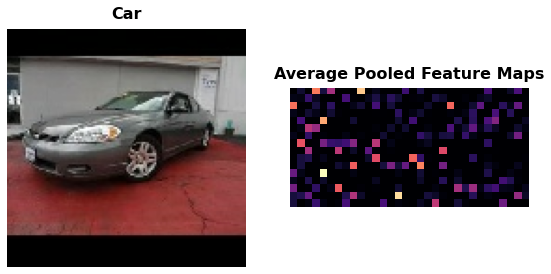

In [32]:
## Global Average Pooling
car = next(ds_iter)

car_tf = tf.image.resize(car[0], size=[128, 128])
car_features = model(car_tf)
car_features = tf.reshape(car_features, shape=(16, 32))
label = int(tf.squeeze(car[1]).numpy())

plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.imshow(tf.squeeze(car[0]))
plt.axis('off')
plt.title(["Car", "Truck"][label])
plt.subplot(122)
plt.imshow(car_features)
plt.title('Average Pooled Feature Maps')
plt.axis('off')
plt.show();

El `global average pooling` se utiliza con frecuencia en las redes convolucionales modernas. Una ventaja es que reduce en gran medida el número de variables del modelo, manteniendo la información sobre la presencia de ciertas características. En aplicaciones como la clasificación, esta información es suficiente para establecer la presencia de ciertas características en la imagen.

## La ventana deslizante

En esta sección abordamos el proceso de extracción de características a través de la **ventana deslizante**, la cual es la base de las  operaciones de convolución y **MaxPooling**. Vamos a analizar los parámetros que gobiernan el comportamiento de la **ventana deslizante** y que se definen en las capas `Conv2D` y `MaxPool2D`: el `stride` y el `padding`. En primer lugar analizamos el papel de la ventana deslizante en el proceso de extracción de características y examinaremos las características generadas.

En primer lugar se visualizan algunas imágenes de prueba y **kernels** típicos, para usarlos a continuación.

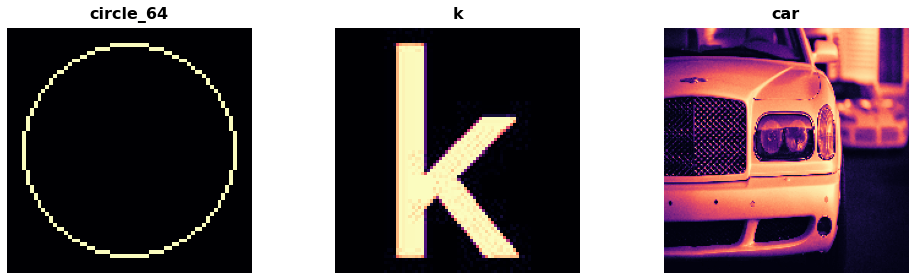

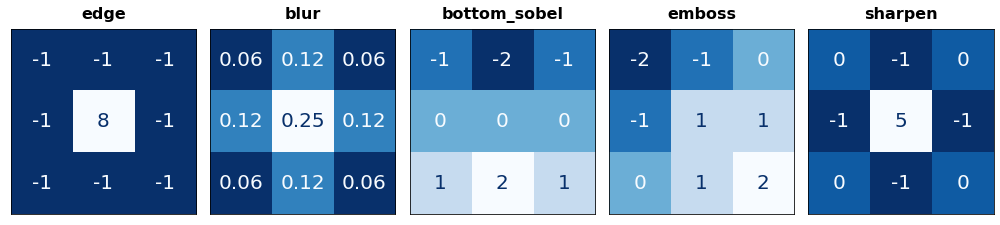

In [19]:
image_dir = 'data_m3/figs/'
circle_64 = tf.expand_dims(circle([64, 64], val=1.0, r_shrink=4), axis=-1)
k = read_image(image_dir + str('k.jpg'), channels=1)
car = read_image(image_dir + str('car_illus.jpg'), channels=1)
car = tf.image.resize(car, size=[200, 200])
images = [(circle_64, "circle_64"), (k, "k"), (car, "car")]

plt.figure(figsize=(14, 4))
for i, (img, title) in enumerate(images):
    plt.subplot(1, len(images), i+1)
    plt.imshow(tf.squeeze(img))
    plt.axis('off')
    plt.title(title)
plt.show();

kernels = [(edge, "edge"), (blur, "blur"), (bottom_sobel, "bottom_sobel"),
           (emboss, "emboss"), (sharpen, "sharpen")]
plt.figure(figsize=(14, 4))
for i, (krn, title) in enumerate(kernels):
    plt.subplot(1, len(kernels), i+1)
    show_kernel(krn, digits=2, text_size=20)
    plt.title(title)
plt.show()

En la celda siguiente introduzca el nombre de la imagen con la que quiere trabajar y el filtro deseado. El nombre de la imagen puede ser: `circle_64`, `k` o `car` (sin comillas). Los filtros pueden ser: `edge`, `blur`, `botton_sobel`, `emboss` y `sharpen`, (sin comillas). Además, configure diferentes combinaciones de parámetros que definen el comportamiento de la ventana deslizante, tanto para la convolución como el **MaxPooling**.

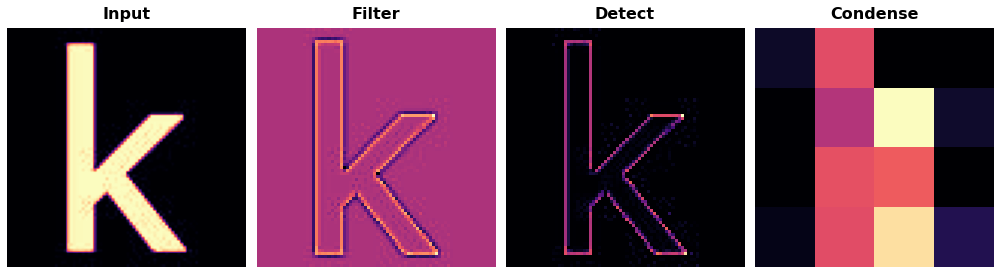

In [41]:
# EJERCICIO 6 --------- TO DO
image = k
kernel = edge

show_extraction(
    image, kernel,
    # EJERCICIO 6 --------- TO DO
    # cambiar las opciones de la ventana deslizante
    conv_stride=1,
    conv_padding='valid',
    pool_size=20,
    pool_stride=20,
    pool_padding='same',
    
    subplot_shape=(1, 4),
    figsize=(14, 6),
)

## Conclusiones

En esta sección se ha realizado un análisis de las operaciones implicadas en una base convolucional para la extracción de características: el **filtrado** de una imagen a través de la **convolución**, la **detección** de características mediante la función de activación **ReLU** y la concentración de características mediante **maximum pooling**. El **MaxPooling** es una herramienta esencial en las redes convolucionales, ya que permite concentrar y reducir el número de características, mejorando la eficiencia de la red. Además, aporta importantes propiedades como la invarianza frente a pequeños desplazamientos. Otro tipo de **pooling** muy utilizado en la cabeza de la red es el **global average pooling**, el cual sintetiza cada mapa de características y los reduce a un solo valor, lo cual es muy interesante en aplicaciones como la clasificación. Hemos analizado los parámetros que gobiernan la ventana deslizante, usada tanto para la **convolución** como para el **MaxPooling** y se ha analizado el campo receptivo de una neurona.

# Preguntas

**La adquisición de las competencias asociadas a las prácticas requieren una explicación propia y rigurosa. Las copias y traducciones literales no demuestran la adquisición de las competencias, por tanto no se considerarán válidas (consultar la rúbrica).**

<div class="alert alert-success">
1. ¿Cuáles son y en qué consisten las tres operaciones básicas del proceso de extracción de características?
</div>

%%%% TO DO %%%%%

La extracción de caracterisicas esta basada en 3 operaciones:





1.   **Filtrado:** Consiste en filtrar la imagen con la que vamos a trabajar. La idea de este filtrado es poder obtener características clave a través de la operación convolución. 
2.   **Detección de caracteristicas:** Tras el filtrado, detectar las características de interés presentes en nuestra imagen bajo estudio. Para poder hacer esta detección empleamos funciones de activación. Tipicamente se emplea la función "ReLu".
3.  **Concentrado de la imagen:** Tras haber filtrado y detectado las caracteristicas de nuestra imagen, debemos aplicar un concentrado a nuestra imagen. Esto se hace con la idea de destacar las caracteriscias que hemos hallado en nuestra imagen. Para hacer esto, tipicamente se emplea la función Max-pooling.



<div class="alert alert-success">
2. ¿Qué relación existe entre el Kernel y el mapa de características? ¿Qué relación existe entre el Kernel y el campo receptivo? 
</div>


%%%% TO DO %%%%%


Un kernel es una herramienta que trabaja sobre nuestra imagen. Se dedica a definir las conexiones entre la entrada y la salida de una capa. A nivel superficial, podemos entender que el Kernel se decia a multiplicar la imagen por sus propios elementos, cosa que genera una suma ponderada.

Esta suma ponderada se hace entre los valores de entrada y los del Kernel, siendo altos si hay cierta similitud entre Kernel e imagen y bajos si no la hay. Es decir, el Kernel actúa como una especia de subrallador. Va a remarcar las zonas que tengan similitud con él mismo, y va a "quitar importancia" a las que no lo sean.

 kernel funciona escaneando una imagen, multiplicando la imagen por los elementos del kernel y generando una suma ponderada entre los valores de la entrada y los del kernel. El valor de la convolución es alto cuando existe similitud entre la imagen y el kernel, y es bajo cuando no existe relación alguna. De este modo, el kernel actuará como una especie de lente polarizada, transmitiendo o atenuando ciertos patrones de información presentes en la entrada.

Esta salida del Kernel en la que se han destacado los valores similares a él, se denomina "Mapa de características". Es decir, el mapa de características es el resultado de haber pasado una imagen por un kernel. Por lo que estos dos conceptossufren una relación directa al generarse uno a través del otro.

Por otro lado, el campo receptivo se puede definir como la cantidad de píxeles con los que va a trabajar nuestra neurona. Es decir, es una medida que indica el nivel de asociación que hay entre la salida de la capa anterior con nuestra neurona.

Esto está relacionado con los Kernel, ya que de ellos vamos a extrar las caracteristicas con las que vamos a trabajar. Esto se entiende mejor en la siguiente imagen, donde vemos que en la capa 1 hay un kernel de 5x5, en la 2 de 3x3 y finalmente todo eso es la entrada de la capa 3. En este caso, decimos que tenemos un campo receptivo de 5x5, pues son el número de características con las que ella va a trabajar.

Aunque no lo pide el enunciado, es importante comentar la importancia de establecer un campo receptivo adecuado. Esto es importante porque establecer un tamaño adecuado del campo receptivo nos va a permitir generar modelos mucho más precisos. Esto se entiende mejor si vemos un caso real del campo receptivo.

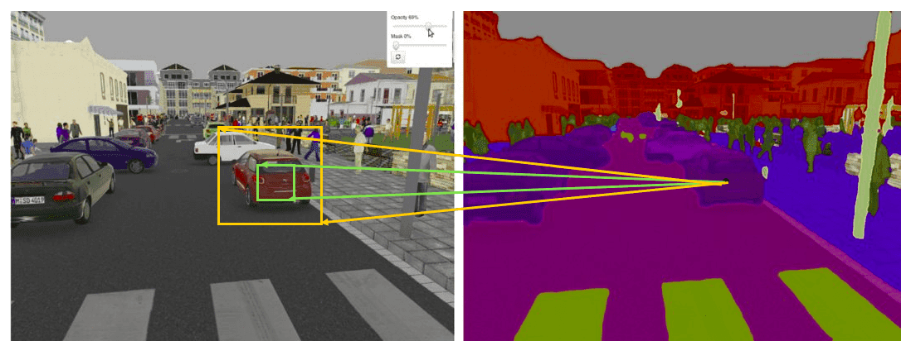

En este caso concreto, aprece lógico que nos interese un campo de recepción pequeñito para poder detectar correctamente el coche. Por lo que este ejemplo ilustra muy bien la idea de que este tamaño debe ajustarse a nuestro problemaadecuadamente.

<div class="alert alert-success">
3. ¿Cuántos parámetros entrenables tiene la siguiente capa? 
    
    ```layers.Conv2D(filters=64, kernel_size=5, activation='relu')```
</div>

%%%% TO DO %%%%%

En esta línea estamos estableciendo un total de 64 Kernels por capa de tamaño 5. Donde además trabajamos con la función de activación "ReLu".

Con esto en mente, como el tamaño del Kernel es 5x5, tenemos un total de 25 parámetros entrenables.


<div class="alert alert-success">
4. A la vista del resultado de la celda "## visualización de la extracción de características". ¿Cumplen los resultados con las expectativas?. Razone la respuesta. 
</div>

%%%% TO DO %%%%%

En este celda lo que tenemos es el resultado de haber pasado la imagen por un Kernel 3x3 configurado para detectar bordes horizontales. Como he explicado ante, al resultado del Kernel hay que aplicarle una función de activación, que en este caso es una "ReLu", para poder resaltar mejor las características que buscamos de la red.

En base a la imagen devuelta, lo que tenemos es la mísma imagen del morro del coche en el cual se ha remarcado con colores más chillones los bordes horizontales detectados. Todo lo que no se ha reconocido como borde horizontal se ha atenuado con un color oscuro. 

Si tenemos en cuenta estas dos cosas, el resultado es lo que esperábamos, ya que efectivamente hemos destacado las características que nos interesaban (bordes horizontales), y la identificación de estas es satisfactoria.

<div class="alert alert-success">
5. A la vista del resultado de la celda "## Análisis numérico de la convolución" y teniendo en cuenta la forma del **Kernel**, ¿qué efecto ha producido el kernel sobre la imagen dada? ¿Es el resultado el esperado? ¿Cuál ha sido el efecto de la función de activación **ReLu**?
</div>


%%%% TO DO %%%%% 

En este caso, tenemos un Kernel que detecta bordes verticales. Como es un Kernel de tamaño 2x2, los bordes que va a detectar no van a ser siempre los únicos presentes. Esto se puede observar si aplicamos un Kernel 3x3 que detecte los mísmos bordes que el de 2x2. La siguiente imagen los compara:

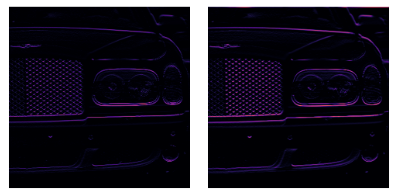

El de la izquierda es el de 2x2, y el de la derecha 3x3. Fijandonos detenidamente, podemos comprobar cómo hay menos bordes en la imagen de la izquierda La culpa de esto la tiene el hecho de que si hacemos una convolución de 2x2 vamos a terminar "suprimiendo" bordes por la naturaleza de la operación de convolucion. Este es uno de los motivos por el cual los Kernel suelen tener tamaño impar, evitar que por como son las comboluciones perdamos posibles bordes.


Pese a todo lo dicho, el único borde vertical presente en la matriz que representa una imagen se ha detectado correctamente,por lo que se cumple lo que esperábamos de manera satisfactoria. Es mas, este es un buen ejemplo para no descartar directamente todos los Kernels que sean pares o inferiores a 3x3. A fin de cuentas, su uso puede ser muy beneficioso si por ejemplo lo aplicamos tras hacer una convolución anterior. Cosa que por ejemplo ocurre en el funcionamiento del modelo "Inception", visto en la práctica anterior.





<div class="alert alert-success">
6. En la celda "## Visualización del maxPooling", obtenga el tamaño de la imagen antes de pasar por el MaxPooling y después. ¿Cuál es la proporción entre los tamaños?
</div>


%%%% TO DO %%%%% 

Para visualizar el tamaño de las imágenes, simplemente he impreso por pantalla las dimensiones de cada imagen. Esto se puede ver en la siguient imagen:

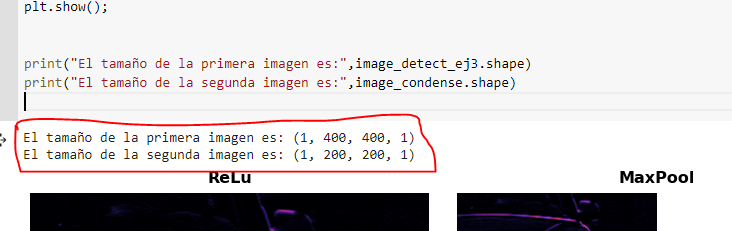

En base a esto podemos comprobar que la reducción del tamaño es del 50%.

<div class="alert alert-success">
7. A la vista del resultado de la celda "###  invarianza frente a pequeños desplazamientos". Suponga que realizamos una pequeña deformación del círculo. ¿Qué efecto esperaría que tuviera en la imagen resultante? ¿Por qué es interesante la invarianza en clasificación? 
</div>

%%%% TO DO %%%%% 

Para poder responder a esto, primero debemos recordar cual es el funcionamiento básico de MaxPooling. Este método calcula el valor máximo dentro de una agrupación que tendrá tamaño "pool_size". 
Esto se hace en una capa, que se diefernecia de las demas al no tener pesos entrenables.

La gracia de esto es no trabajar con valores irrelevantes en nuestra red, motivo por el cual aplicamos MaxPooling. Ya que nos agrupa la información permitiendonos trabajar solo con la párte más relevante del mísmo.

Con esta idea en mente, si le añadimos una **pequeña** deformación al círculo, conforme vayamos aplicando MaxPooling, se irá manteniendo hasta que eventualmente desaparezca por completo. Sin embargo, pese a que tengamos una deformación, el MaxPooling no va a deformar completamente el círculo gracias a la invarianza.


**¿Por qué es interesante la invarianza en clasificación?**

Tal y como he comentado antes, he afirmado que con MaxPooling eliminamos zonas sin valor para nuestro modelo, como puede ser por ejemplo un pixel en negro.

Sin embargo, decir que estos píxeles no tienen vañor es una verdad a medias. Ya que sin estos píxeles negros, no tenemos información de referencia. Y tener información de referencia si que es importante, sobretodo si queremos conocer la posición durante el proceso de MaxPooling.

Es decir, la invarianza lo que nos va a dar es la seguridad de que, auqnue apliquemos el MaxPooling, no corramos el riesgo de perder esta información de referencia. Cosa que nos permite deformar ligeramente el círculo, y que esta deformación no se adueñe del resultado del MaxPooling. 



<div class="alert alert-success">
8. A la vista del resultado de la celda "## Global Average Pooling" del tutorial. ¿Cuál es el factor de reducción en las características provocado por el Global average pooling?
</div>

%%%% TO DO %%%%% 

El global average pooling consiste en los mapas de características de las CNN con capas completamente conectadas por su valor promedio. Esto se suele usar como alternativa a las capas Dense en la cabeza de la red.

En el ejemplo, lo que nos genera es precisamente mapas de características aleatorios, para que al aplicar el  Global Average Pooling nos quede el valor promedio.

Como cada mapa de características presenta 25 de ellas, y al final tenemos una sola, el factor de reducción es 1/25. Motivo por el cual se dice que el Global Average Pooling es destructivo, ya que "elimina" gran parte de las características.

Sin embargo, esto no es preocupante, ya que esto suele aplicarse en problemas de clasificación, donde nos interesa saber si está presente o no una característica. Motivo por el cual podemos reducir tanto el número de estas.

<div class="alert alert-success">
9. A la vista del resultado de la celda "## Global Average Pooling" de este cuaderno. ¿Cómo interpreta el mapa de características de la figura de la derecha? ¿Qué significan los valores claros frente a los oscuros? ¿Cuál sería la tarea de la cabeza para clasificar los coches y camiones adecuadamente?
</div>


%%%% TO DO %%%%% 

Una vez entendido que hace el Global Average Pooling, queda claro que a la drecha tenemos los valores promedios de cada mapa de caracteristicas de nuestro modelo. Para nuestros no parece que tenga valor, pero el modelo puede determinar en función de los colores de cada caracteristica el tipo de detección correspondiente.

De hecho, los colores si que nos dan más información, ya que cuanto más claros sean significa que la media de las caracteristicas es bastante similar y elvada, por lo que es un buen indicio de que efectivamente esa caracteristica corresponde a lo que estemos clasificando. Coches o camiones en este caso.
Por otro lado, si es oscuro significa lo contrario, las caracteristicas nos indican que no estamos ante nada que se parezca a lo que clasifica nuestro modelo.


Sabiendo esto, la cabeza debe interpretar cada una de estas características para poder catalogar las imagenes entre coches o camiones. Cuanto más claras sean estas características, más seguridad tendrá el modelo de que efectivamente tenemos una de estas dos cosas.

<div class="alert alert-success">
10. A la vista de la figura que ilustra el campo receptivo de una neurona en el tutorial, si se añade una tercera capa convolucional con un núcleo de $3 x 3$. ¿Qué campo receptivo tendrán sus neuronas? 
</div>


%%%% TO DO %%%%% 

En la foto del ejemplo tenemos una capa con núcleo 5x5, otra 3x3 y la final. De forma que la final tiene un campo receptivo 5x5.

Ahora, entre la 5x5 y 3x3 vamos a colocar otra 3x3. Por lo que, extrapolando la explicación de después, tendremos un campo receptivo de tamaño 6x6. 

<div class="alert alert-danger">
Pregunta avanzada:

En el ejercicio 6:
- Describa las características que se obtienen con cada filtro y el efecto que produce el `strides` en la convolución.
- Describa el efecto del tamaño y el `strides` de la ventana del MaxPooling sobre el mapa de características.    
</div>

%%%% TO DO %%%%%

En estas 4 imágenes, tenemos el paso por los procesos descritos en la pregunta 1 que debemos hacer para poder extraer caracteristicas.

Primero, obtenemos el resultado de hacer una convolución en la imagen a tratar. Segundo, aplicamos la detección a través de una función de activación, y finalmente realizamos el maxPooling al resultado.

Strides es un parámetro empleado por MaxPooling,que define cada cuánto se mueve la ventana de agrupación para cada paso de dicha agrupación. Es decir, va el número de veces que agrupamos características en una ventana hace sus medias en cada una de estas. Su relación con la convolución es el número de valores totales que vamos a sacar tras hacer las medias.


Size marca el tamaño de esta ventana, por lo que si la establecemos con un valor bajo, como por ejemplo 2, el MaxPooling nos va a mantener correctamente el contorno. Si nos pasamos, cada vez iremos deformando más y más la imagen, por culpa de que la media se realiza con cada vez mas parámetros, cosa que no siempre puede tener sentido, al no estar relacionados entre si.

Esto se aprecia en la siguiente imagen, donde he establecido un tamaño de 20. Cosa que ha dado como resultado un valor deformado, pese a que se asemeje a una K.

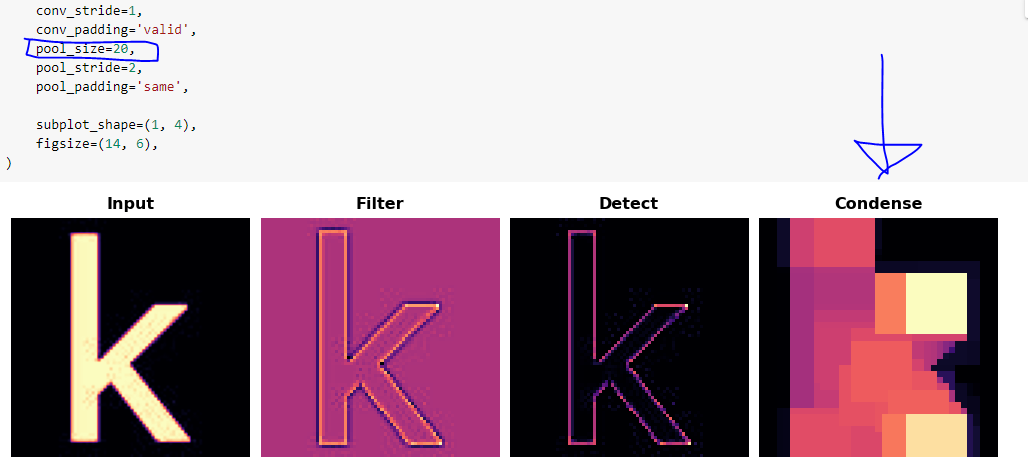



Conforme variemos el valor strides, el número de veces que desplazamos la ventana va a cambiar, por lo que podemos tener o muchas medias o muy pocas. Esto puede implicar que tengamos dos extremos. Uno en el que tengamos poca información con la que tomar una decisión de clasificación por haber dado saltos muy grandes, y otro en el cual hagamos lo contrario, tengamos muchas muestras por haber dado saltos pequeños. 

Si al caso anterior donde el size era 20, establecemos saltos de 20, podemos ver el efecto tan negativo que tiene un mal establecimiento de estos valores.

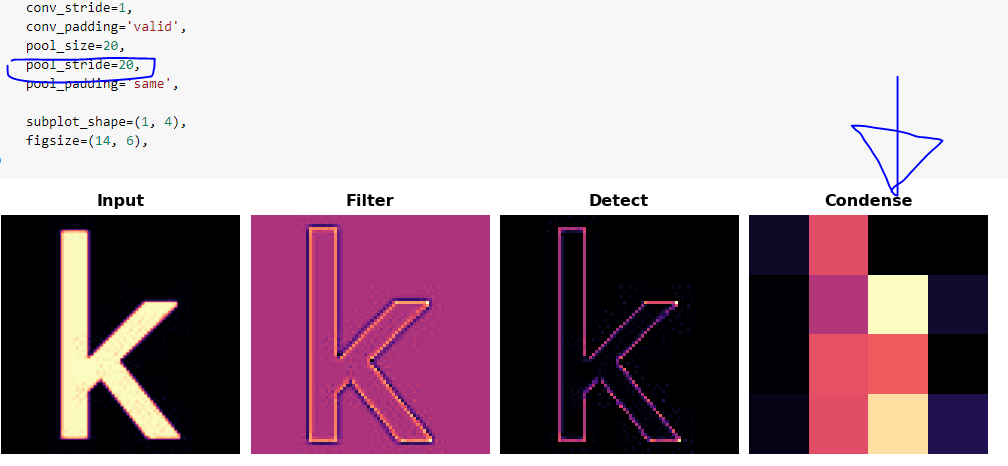

Sin embargo, como es usual al tratar con redes neuronales, no existen valores necesariamente malos o buenos. Esto depende de nuestra aplicación en concreto.